# 天气图像分类识别及变换

通过手动提取特征识别天气图像的类别，并根据不同的天气变换图像

## 图像特征提取

提取图像天气信息特征主要是通过两个方法，一个是雾度特征，另一个是饱和度对比度特征识别。第一种方法得到200维的特征向量，第二种方法得到100维的特征向量。

In [2]:
# import base modules
import cv2;
import numpy as np
import os
from matplotlib import pyplot as plt
import time

In [2]:
data_path = '../datasets/MWD/'
chosed_pic = "cloudy/cloudy_00000.jpg"
file_path = os.path.join(data_path, chosed_pic)
file_path

'../datasets/MWD/cloudy/cloudy_00000.jpg'

In [4]:
def showimg(img, title="test show"):
    cv2.imshow(title, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [5]:
# 查看一幅图片
img = cv2.imread(os.path.join(data_path, chosed_pic))
showimg(img)

### 雾度特征提取

将每张天气图像划分为10x10的无重叠的块，然后使用这些区域中暗通道的均值来形成200维向量
$$
J^{dark}(x)=\min_{c\in\{r,g,b\}}(\min_{y \in \Omega(x)}(J^C(y)))
$$
其中，$J^C$是图片J的颜色通道，$\Omega(x)$是以x为中心的局部区域，$J^{dark}$即为图片$J$的暗通道值，对三个颜色通道计算得到的暗通道值求均值，得到100维的向量

In [6]:
def darkVector(img, m=10, n=10):
    """
        获取图像雾度特征
        @ param: 
            img-输入的图像
            m: 分块的宽度，默认为10
            n: 分块的长度，默认为10
        @ return:
            返回值为mxn维的暗通道向量
    """
    # 获取图像的基本信息
    height, width, channel = img.shape
    grid_h = int(height*1.0/(m-1)+0.5)
    grid_w = int(width*1.0/(n-1)+0.5)

    # 满足整除关系的高、宽
    h=grid_h*(m-1)
    w=grid_w*(n-1)
    # 图像缩放
    img_re = cv2.resize(img, (w, h), cv2.INTER_LINEAR)
    gx, gy = np.meshgrid(np.linspace(0, w, n), np.linspace(0, h, m))
    gx = gx.astype(np.int)
    gy = gy.astype(np.int)

    dark_img = np.zeros([m, n], np.uint8)
    for i in range(m-1):
        for j in range(n-1):
            for k in range(channel):
                # 计算分块区域的最小值
                dark_img[i,j] += np.min(img_re[gy[i, j]: gy[i+1, j+1], gx[i, j]:gx[i+1, j+1],:])
            dark_img[i, j] /= channel # 计算各个通道平均值

    return dark_img

In [7]:
dark = darkVector(img,10,10);
dark.shape
showimg(dark, "dark vector")

<ipython-input-6-cd2e78161af7>:30: RuntimeWarning: overflow encountered in ubyte_scalars
  dark_img[i,j] += np.min(img_re[gy[i, j]: gy[i+1, j+1], gx[i, j]:gx[i+1, j+1],:])


### 

### 饱和度特征提取

通过以下公式计算每个像素的归一化饱和度，然后计算图像归一化饱和度的直方图，形成100维特征向量，作为天气图像的全局特征。
$$
S(x,y)=\frac{S_{x,y}-min(S_I)}{max(S_I)-min(S_I)}
$$

在处理中，首先将BGR类型(opencv的imread函数以**BGR**格式加载图像)的图像转换为HSV类型，或者说是颜色空间，相关HSV空间的介绍可以参照[HSV空间各通道分离实验——直观了解各通道数值的意义
](https://blog.csdn.net/bamboocan/article/details/70627137)

In [8]:
def saturationVector(img):
    """
    获取图像饱和对比度特征
    @ params:
        img-输入的原始图像
    return:
        返回的是图像归一化饱和度的直方图，为100维特征
    """
    # bgr转换为hsv，并分离出饱和度通道s
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    height, width, col = img.shape
    # 归一化饱和度
    _range = np.max(s)-np.min(s)
    s_img = np.zeros((100,1), np.float32)
    s_img = (s-np.min(s))/_range
    s_img = s_img.astype(np.float32)
    hist = cv2.calcHist([s_img], [0], None, [100], [0, 1])
    return s_img, hist

In [9]:
s_img, hist = saturationVector(img)

In [10]:
showimg(s_img, "saturation picture")
s_img.shape

(400, 526)

In [11]:
hist.shape

(100, 1)

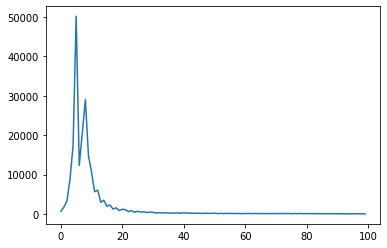

In [12]:
plt.plot(hist)
plt.show()

### 图像转换为特征

读取全体的图像，得到其对应的特征为输入变量，根据对应的文件夹得到label

In [4]:
folderlist = os.listdir(data_path)
folderlist

['cloudy', 'sunny', 'rainy']

In [14]:
filenum = 0
for folder in folderlist:
    inner_path = os.path.join(data_path, folder)
    filelist = os.listdir(inner_path)
    filenum += len(filelist)
filenum

NotADirectoryError: [Errno 20] Not a directory: '../datasets/classification/weather_classification/labels.bin'

In [5]:
label2arr = dict(zip(folderlist, range(len(folderlist))))
label2arr

{'cloudy': 0, 'sunny': 1, 'rainy': 2}

In [32]:
# 读取图像转换特征和标签
features = np.zeros((filenum, 200), np.float32)
labels = np.zeros((filenum, 1), np.uint8)
# label2arr = {"cloudy": 0, "rainy":1, "sunny":2}
label2arr = dict(zip(folderlist, range(len(folderlist))))
cnt = 0
start_time = time.time()
start_time_1 = time.time()
for folder in folderlist:
    inner_path = os.path.join(data_path, folder)
    filelist = os.listdir(inner_path)
    for file in filelist:
        filepath = os.path.join(inner_path, file)
        try:
            img = cv2.imread(filepath)
            dark_img = darkVector(img)
            dark_img = dark_img.reshape((100, 1))
            s_img, hist = saturationVector(img)
        except:
            continue
        
        labels[cnt] = label2arr[folder]
        hist = hist.reshape((100, -1))
        features[cnt] = np.concatenate((dark_img, hist),axis=1).flatten()
        cnt += 1
        if cnt % 5000 == 0:
            time_cost = time.time() - start_time
            start_time = time.time()
            print("——————processing progress：%lf %% costing time this round %lf——————" % (cnt/filenum*100, time_cost))
    
print("features and labels process success, total process costed time: %lf" % (time.time() - start_time_1))

<ipython-input-18-cd2e78161af7>:30: RuntimeWarning: overflow encountered in ubyte_scalars
  dark_img[i,j] += np.min(img_re[gy[i, j]: gy[i+1, j+1], gx[i, j]:gx[i+1, j+1],:])
<ipython-input-20-d67f8eb8adf0>:16: RuntimeWarning: invalid value encountered in true_divide
  s_img = (s-np.min(s))/_range
——————processing progress：50.000000 % costing time this round 13.659497——————
——————processing progress：100.000000 % costing time this round 13.550995——————
features and labels process success, total process costed time: 27.210623


In [33]:
features.shape

(10000, 300)

In [34]:
labels.shape

(10000, 1)

In [35]:
labels

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]], dtype=uint8)

In [36]:
# 保存numpy矩阵
features_path = os.path.join(data_path, "features.bin")
labels_path = os.path.join(data_path, "labels.bin")

features.tofile(features_path)
labels.tofile(labels_path)